In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from pylops.utils.seismicevents import makeaxis, linear2d, hyperbolic2d
from pylops.utils.wavelets import ricker
from PIL import Image, ImageDraw, ImageFilter
import random

par = {'ox':0, 'dx':12.5, 'nx':192, # offsets
       'ot':0, 'dt':0.004, 'nt':192, # time
       'f0': random.randint(5,30), 'nfmax': 50} 


def remake_axis():
    
    par = {'ox':0, 'dx':12.5, 'nx':192, # offsets
           'ot':0, 'dt':0.004, 'nt':192, # time
           'f0': random.randint(5,6), 'nfmax': 50} 

    # Make canvas
    return makeaxis(par)

# Make wavelet
wav = ricker(np.arange(40) * par['dt'],f0=par['f0'])[0]

v = 1500


/home/haiwen/anaconda3/envs/nst/lib/python3.6/site-packages/pylops/utils/wavelets.py:31: UserWarning: one sample removed from time axis...
  warnings.warn('one sample removed from time axis...')


In [1]:
def normalize(img, min_val = 0, max_val = 1):
    return (img - np.min(img)) / (np.max(img) - np.min(img)) * (max_val - min_val) + min_val

# Make line shaped synthetic seismic
def generate_linear(lines):
    t, t2, x, y = remake_axis()
    # position in x=0
    t0 = [random.uniform(t.min(),t.max()) for _ in range (lines)]
    # angle egree = 0
    theta = [0 for i in range (lines)]
    # intensity
    amp = [random.uniform(-2,2) for _ in range (lines)]
    # make linear2d
    mlin, mlinwav = linear2d(x, t, v, t0, theta, amp, wav)
    
    return mlinwav

def generate_parabolic(lines, random_flag):
    t, t2, x, y = remake_axis()
    # position in x=0
    t0 = [random.uniform(t.min(),t.max()) for _ in range (lines)]
    # intensity
    amp = [random.uniform(-2,2) for _ in range (lines)]
    # y = t0 + px*x + pxx*(x^2)
    if random_flag:
        px = [random.uniform(1e-9, 1e-4) for _ in range (lines)]
        pxx = [random.uniform(-1e-9, -1e-7) for _ in range (lines)]
    else:
        t_px = random.uniform(4e-6, 1e-5)
        px = [t_px for _ in range (lines)]
        # make a symmetry axis
#         symmetry_axis = random.uniform(x.min(),x.max())
#         pxx = [- (t_px) / (2 * symmetry_axis) for _ in range (lines)]
        if random.randint(0,1) > 0:
            negetive = 1
        else:
            negetive = -1
        t_pxx = random.uniform(negetive * 4e-8, negetive * 1e-10)
        pxx = [t_pxx for _ in range (lines)]
    print(px[0],pxx[0])
    # make parabolic2d
    mpar, mparwav = parabolic2d(x, t, t0, px, pxx, amp, wav)
    return mparwav

# Simulate a Fault
def make_fault(raw_data, times):
    # Find a direction (line, x-ky+b=0)
    # keep it same in every fault
    t_k = random.uniform(1, 6)
    from scipy.ndimage.interpolation import rotate
    rotated = rotate(raw_data, angle=45)
    annotation = np.zeros((raw_data.shape[0], raw_data.shape[1]))
    for _ in range(times):
    
        # Move down n pixels
        t_offset = random.randint(-8,8)
#         # Simulate gaps
#         gap = random.randint(0, 8)
#         if gap < 5:
#             gap = 0
#         # if need gap
        flip = random.randint(0, 1)
        # cancel the gap
        gap = 0
        
        final_im = np.zeros((raw_data.shape[0]+abs(t_offset), int(raw_data.shape[1]+abs(t_offset)/t_k)+gap))
        final_annotation = np.zeros((raw_data.shape[0]+abs(t_offset), int(raw_data.shape[1]+abs(t_offset)/t_k)+gap))

        t_b = random.uniform(-raw_data.shape[0]/2, raw_data.shape[1]*t_k*2/3)
        # do fault cutting
        for i in range(raw_data.shape[0]):
            for j in range(raw_data.shape[1]):
                if i-t_k*j+t_b>-0.5:
                    final_im[i,j] = raw_data[i,j]
                else:
                    final_im[i+t_offset,int(j+t_offset/t_k)+gap] = raw_data[i,j]
                if t_k>i-t_k*j+t_b>-t_k and t_offset != 0:
                    final_annotation[i,j]=1
                else:
                    final_annotation[i,j] = annotation[i,j]
        raw_data = final_im
        annotation = final_annotation
        if flip > 0:
            final_im = np.fliplr(final_im)
            final_annotation = np.fliplr(final_annotation)
    return final_annotation, final_im

In [ ]:
import scipy.signal as filt

def parabolic2d(x, t, t0, px, pxx, amp, wav):

    if isinstance(t0, (float, int)):
        t0 = (t0,)
    if isinstance(px, (float, int)):
        px = (px,)
    if isinstance(pxx, (float, int)):
        pxx = (pxx,)
    if isinstance(amp, (float, int)):
        amp = (amp,)

    # identify dimensions
    dt = t[1] - t[0]
    wcenter = int(len(wav) / 2)
    nx = np.size(x)
    nt = np.size(t) + wcenter
    nevents = np.size(t0)

    # create events
    d = np.zeros((nx, nt))
    for ievent in range(nevents):
        tevent = t0[ievent] + px[ievent] * x + pxx[ievent] * x ** 2
        tevent = (tevent - t[0]) / dt
        itevent = tevent.astype(int)
        dtevent = tevent - itevent
        for ix in range(nx):
            if itevent[ix] < nt - 1 and itevent[ix] >= 0:
                d[ix, itevent[ix]] += amp[ievent] * (1 - dtevent[ix])
                d[ix, itevent[ix] + 1] += amp[ievent] * dtevent[ix]
    
#     _, d = make_fault(d, 2)
    
    d, dwav = _filterdata(d, nt, wav, wcenter)
    
    _, dwav = make_fault(dwav.T, 2)
    
    plt.imshow(dwav)
    
    # filter events with certain wavelet
    return d, dwav
                
def _filterdata(d, nt, wav, wcenter):
    r"""Apply filtering to data with wavelet wav"""
    dwav = filt.lfilter(wav, 1, d, axis=-1)
    dwav = dwav[..., wcenter:]
    d = d[..., : (nt - wcenter)]
    return d, dwav

9.05125449274117e-06 3.066841252621214e-08
(198, 194)
9.644302183899171e-06 -8.216587728791658e-10
(202, 194)
9.801692427697057e-06 -3.137314258709002e-08
(196, 193)
6.816537024573561e-06 -2.4467055722869214e-08
(199, 196)
8.493703727230789e-06 -2.8197666759953174e-08
(199, 196)
4.540814832842798e-06 -2.5615704836312767e-08
(201, 193)
9.872083826250835e-06 7.672011265352994e-09
(200, 192)
4.834046919938368e-06 -3.82013051196287e-08
(197, 193)
6.1664685854154316e-06 3.7950151281914565e-08
(201, 193)
4.689581756167728e-06 1.506316859197493e-08
(199, 194)
7.746500886620802e-06 1.3627621212019966e-08
(204, 198)
7.639260148620696e-06 -3.888666755098869e-08
(198, 193)
6.685854993149496e-06 2.6327401632496853e-08
(201, 193)
4.494097559258219e-06 3.9401102162972106e-08
(200, 193)
8.923943213245529e-06 -1.539867588285053e-08
(197, 193)
6.592828118835249e-06 -2.603855646003249e-08
(199, 196)
8.995090783075862e-06 1.7687196600115946e-08
(197, 192)
5.435903505582973e-06 -1.769522077269186e-08
(202

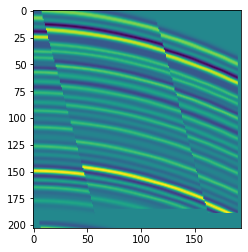

In [4]:
max_pic = 1000
for i in range(0, max_pic // 2):
#     noise_strength = random.randint(3,11)
#     np.save('/home/haiwen/noise_reduction/data/only_gaussian/{}.npy'.format(i), normalize(np.random.normal(loc=0,scale=noise_strength * 10,size=(192,192)),0,255))
#     continue
    # Make wavelet
    wav = ricker(np.arange(random.randint(10,20)) * par['dt'],f0=par['f0'])[0]
    
    # Make line shaped synthetic seismic
    lines = random.randint(40,90)
    mlinwav = generate_linear(lines).clip(-2,2)

    # Make parabolic shaped synthetic seismic
    lines = random.randint(40,90)
    mparwav = generate_parabolic(lines, False).clip(-2,2)

    annotation_lin, mlinwav = make_fault(mlinwav.T, 2)
#     annotation_par, mparwav = make_fault(mparwav.T, 2)
    mlinwav = normalize(mlinwav,0,255)
    mparwav = normalize(mparwav,0,255)
    print(mlinwav.shape)
    
    stx = 25
    sty = 25
#     np.save('data/synthetic_for_fault_seismic/s{}.npy'.format(i), mparwav[stx:stx+192,sty:sty+192])
#     np.save('data/synthetic_for_fault_annotation/s{}.npy'.format(i), annotation_par[stx:stx+192,sty:sty+192])
#     np.save('data/synthetic_for_fault_annotation/s{}.npy'.format(i), annotation_lin[stx:stx+192,sty:sty+192])
#     np.save('data/synthetic_full_raw/s{}.npy'.format(max_pic + i), mparwav[stx:stx+192,sty:sty+192])
#     print (mlinwav.std())
    # add gussain noise
    noise_strength = random.randint(3,11)
    noise_linear = np.random.normal(loc=0,scale=noise_strength*10, size=mlinwav.shape)
    noise_parablic = np.random.normal(loc=0,scale=noise_strength*10, size=mparwav.shape)

    np.save('./noise_patches/c_synthetic_s_gaussian/{}_gaussian.npy'.format(i*2), (mlinwav+noise_linear)[stx:stx+128,sty:sty+128])
    np.save('./noise_patches/c_synthetic_s_gaussian/{}_gaussian.npy'.format(i*2+1), (mparwav+noise_parablic)[stx:stx+128,sty:sty+128])

    np.save('./dataset_patches/synthetic_content/{}.npy'.format(i*2), mlinwav[stx:stx+128,sty:sty+128])
    np.save('./dataset_patches/synthetic_content/{}.npy'.format(i*2+1), mparwav[stx:stx+128,sty:sty+128])
    
    
#     for noise_strength in range(3, 15, 2):
#         noise_linear = np.random.normal(loc=0,scale=noise_strength * 10, size=mlinwav.shape)
#         noise_parablic = np.random.normal(loc=0,scale=noise_strength * 10, size=mparwav.shape)
#         np.save('/home/haiwen/noise_reduction/data/synthetic_multi_{}/s{}.npy'.format(noise_strength * 10, i), normalize(mlinwav+noise_linear,0,255)[stx:stx+192,sty:sty+192])
#         np.save('/home/haiwen/noise_reduction/data/synthetic_multi_{}/s{}.npy'.format(noise_strength * 10, max_pic//2 + i), normalize(mparwav+noise_parablic,0,255)[stx:stx+192,sty:sty+192])

#     np.save('/home/haiwen/noise_reduction/data/synthetic_multi/s{}.npy'.format(i), mlinwav[stx:stx+192,sty:sty+192])
#     np.save('/home/haiwen/noise_reduction/data/synthetic_multi/s{}.npy'.format(max_pic // 2 + i), mparwav[stx:stx+192,sty:sty+192])

    

[[ 92.77356391  90.26710458  87.55917923 ...  33.27361691  36.46819789
   39.65999818]
 [156.72584116 154.89988663 152.75018172 ...  18.35901489  17.83877633
   17.3140343 ]
 [168.44476204 168.46560901 168.3788911  ...  70.89509074  67.21182608
   63.51557566]
 ...
 [223.92509159 223.1960837  222.2906247  ... 126.45043255 126.42487288
  126.39922591]
 [241.88638342 242.95637392 243.59975305 ... 154.85130806 152.39565869
  149.93162184]
 [182.79350979 186.02848114 188.8878489  ... 209.82979282 206.71438604
  203.58833833]]


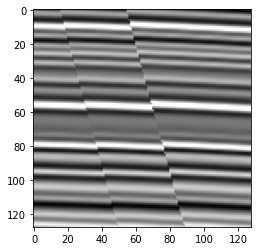

In [26]:
plt.imshow(mparwav[stx:stx+128,sty:sty+128], cmap='gray')
print(mparwav[stx:stx+128,sty:sty+128])

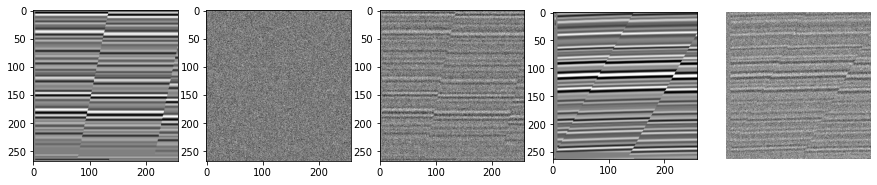

In [5]:
fig, axs = plt.subplots(1, 5, figsize=(15,3))
plt.axis('off')
axs[0].imshow(mlinwav, cmap='gray')
axs[1].imshow(noise_linear,  cmap='gray')
axs[2].imshow(mlinwav+noise_linear, cmap='gray')
axs[3].imshow(mparwav,  cmap='gray')
axs[4].imshow(mparwav+noise_parablic, cmap='gray')

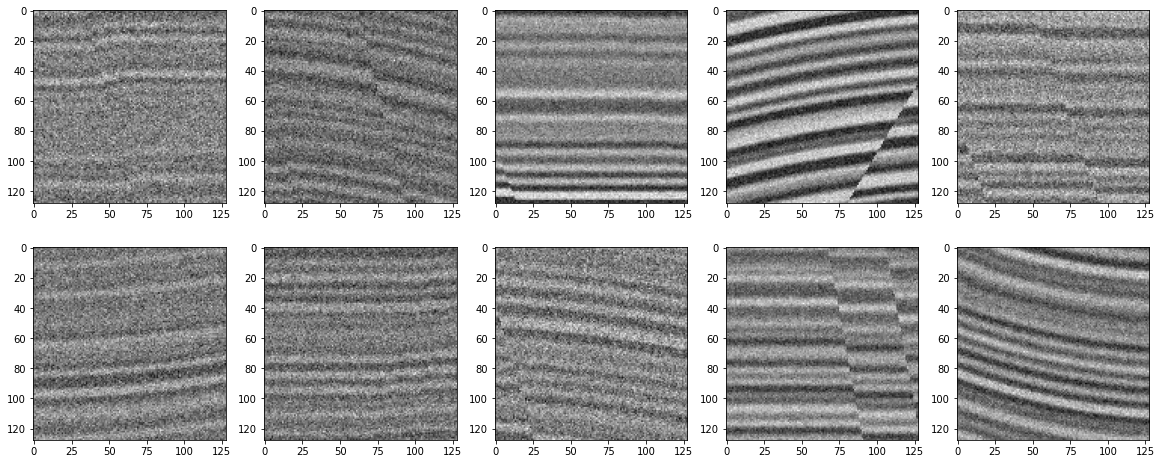

In [15]:
import math
lines = 2
rows = 5 
plt.figure(figsize=(20, lines * 4))
for i in range(10):
    pic = np.load('/home/haiwen/noise_reduction/data_final/noise_raw_data/synthetic_multi/{}.npy'.format(i))
    plt.subplot(lines, rows, i+1)
    plt.imshow(pic,  cmap='gray')